# PPL Example 1: Activity Choice (without Context)

In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

In [2]:
def model(data=None):
    alpha = jnp.repeat(1, 4)
    theta = numpyro.sample('theta', dist.Dirichlet(alpha))
    obs = numpyro.sample('obs', dist.MultinomialProbs(theta), obs=data)

In [3]:
# cycling, picnic, climbing, movie = 20, 20, 20, 40
data = jnp.array([20, 20, 20, 40])

In [4]:
# Parameter estimation
random_key = random.PRNGKey(42)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=1)
mcmc.run(random_key, data=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2487.70it/s, 7 steps of size 7.39e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.20      0.04      0.20      0.14      0.26   1993.52      1.00
  theta[1]      0.20      0.04      0.20      0.13      0.26   1715.87      1.00
  theta[2]      0.20      0.04      0.20      0.13      0.26   1723.11      1.00
  theta[3]      0.39      0.05      0.40      0.32      0.48   1878.22      1.00

Number of divergences: 0


In [5]:
# Store the posterior samples
import pickle

samples = mcmc.get_samples()
with open('samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

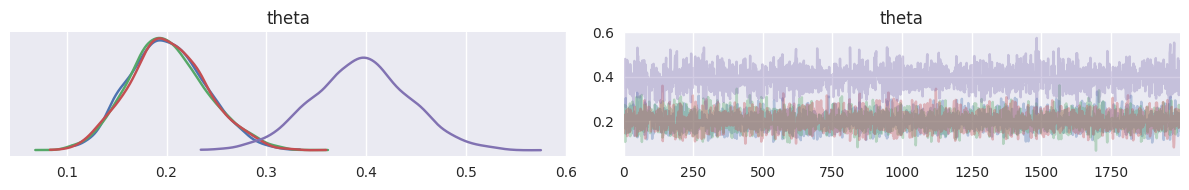

In [6]:
import arviz as az
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

trace = az.from_numpyro(mcmc)
axes = az.plot_trace(trace)
plt.tight_layout()

plt.show()

In [7]:
import pickle

with open('samples.pkl', 'rb') as f:
    samples = pickle.load(f)

random_key = random.PRNGKey(1)
predictive = Predictive(model, samples, return_sites=['obs'])
pred = predictive(random_key)

def activity_name(activity_array: jnp.ndarray) -> str:
    idx = jnp.argmax(activity_array)
    return ["cycling", "picnic", "climbing", "movie"][idx]

for i in range(10):
    activity = activity_name(pred["obs"][i])
    print(f"Activity: {activity}")

Activity: movie
Activity: climbing
Activity: cycling
Activity: movie
Activity: movie
Activity: movie
Activity: movie
Activity: climbing
Activity: movie
Activity: movie


# PPL Example 2 Activity Choice with Context

In [8]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

In [9]:
data = jnp.array([[0, 0, 15, 10],
                  [15, 5, 0, 5],
                  [0, 0, 5, 20],
                  [5, 15, 0, 5]])

mood = jnp.array([0, 0, 1, 1])
weather = jnp.array([0, 1, 0, 1])

In [10]:
def model(mood, weather, obs=None):
    lam = numpyro.sample("lam", dist.Exponential(rate=1.0)) 
    
    beta_mood = numpyro.sample(
        "beta_mood", 
        dist.Exponential(rate=lam).expand((2, 4))
        )
    beta_weather = numpyro.sample(
        "beta_weather", 
        dist.Exponential(rate=lam).expand((2, 4))
        )
    beta_0 = jnp.repeat(1, 4)
    
    with numpyro.plate("context", 4):
        concentration = numpyro.deterministic(
            "concentration", 
            beta_0 + beta_mood[mood, :] + beta_weather[weather, :]
            )
        theta = numpyro.sample(
            "theta", 
            dist.Dirichlet(concentration=concentration)
            )
        numpyro.sample("obs", dist.Multinomial(probs=theta), obs=obs)

In [11]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=1)
mcmc.run(random.PRNGKey(12345), obs=data, mood=mood, weather=weather)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1195.70it/s, 15 steps of size 2.47e-01. acc. prob=0.90]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_mood[0,0]      0.44      0.58      0.26      0.00      1.02    804.83      1.00
   beta_mood[0,1]      0.31      0.35      0.19      0.00      0.74   1280.60      1.01
   beta_mood[0,2]      0.44      0.56      0.26      0.00      1.06    943.18      1.00
   beta_mood[0,3]      0.63      0.90      0.38      0.00      1.45    541.73      1.00
   beta_mood[1,0]      0.32      0.40      0.20      0.00      0.74   1063.52      1.00
   beta_mood[1,1]      0.46      0.69      0.26      0.00      1.06    596.77      1.00
   beta_mood[1,2]      0.31      0.37      0.19      0.00      0.71   1072.80      1.00
   beta_mood[1,3]      0.93      1.29      0.52      0.00      2.24    601.87      1.00
beta_weather[0,0]      0.23      0.26      0.15      0.00      0.55   1175.76      1.00
beta_weather[0,1]      0.22      0.27      0.14      0.00      0.51   1494.85      1.00
beta_weather[0,2]      1.06    

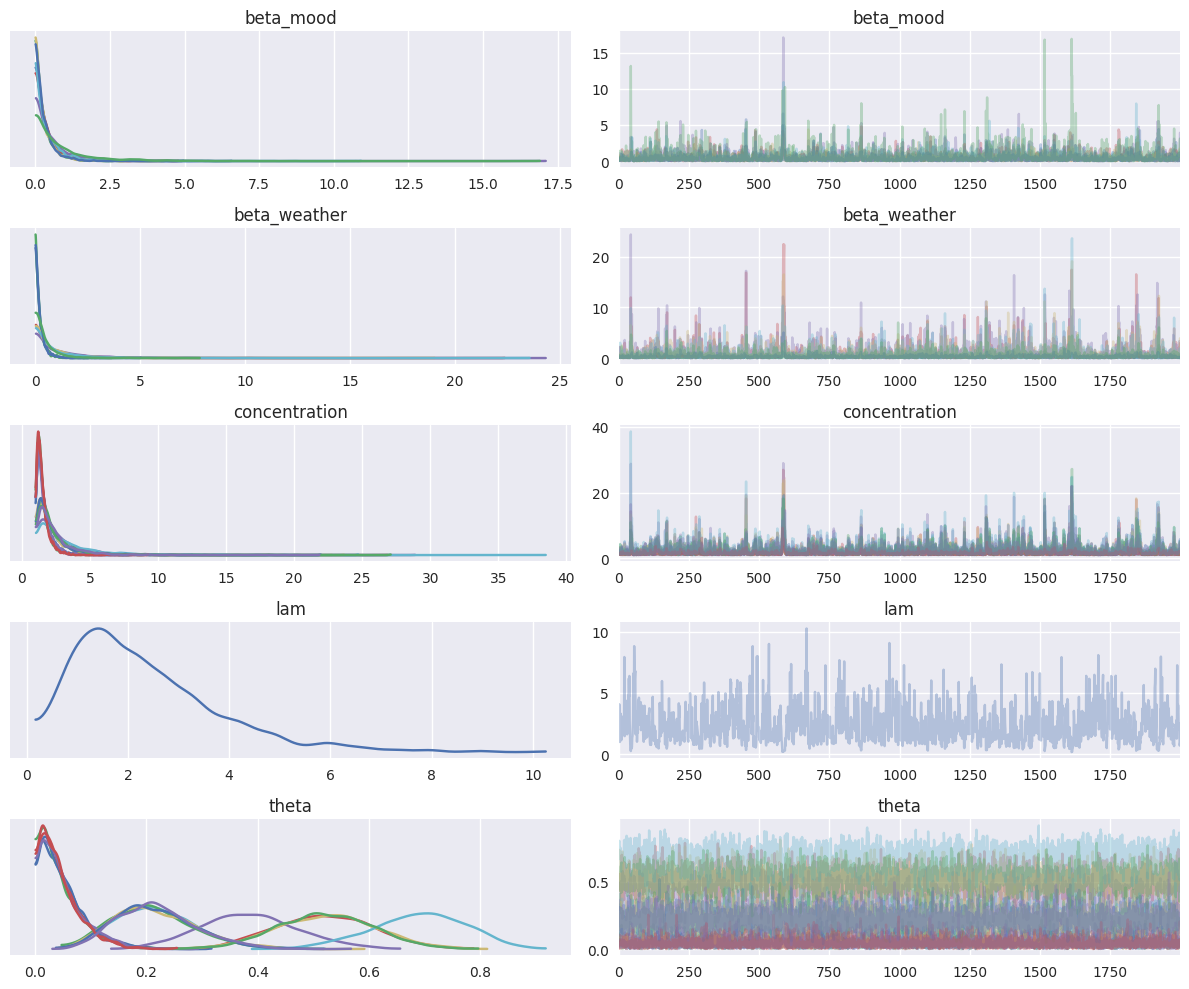

In [12]:
import arviz as az
import matplotlib.pyplot as plt

trace = az.from_numpyro(mcmc)
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [13]:
samples = mcmc.get_samples()
predictive = Predictive(model, samples, return_sites=['obs', 'theta'])
pred = predictive(random.PRNGKey(1), mood=mood, weather=weather)
thetas = pred["theta"] 
print(jnp.mean(thetas, axis=0))

[[0.04949357 0.04603111 0.51976717 0.38470826]
 [0.5234336  0.2168804  0.04946552 0.21022044]
 [0.04532033 0.04884466 0.21565485 0.69018024]
 [0.21473768 0.5212052  0.04489085 0.21916634]]


In [14]:
def ctx2idx(mood: str, weather: str) -> int:
    m = 2 if mood == "chill" else 0
    w = 1 if weather == "sunny" else 0
    return m + w
    
def activity_name(activity_array: jnp.ndarray) -> str:
    idx = jnp.argmax(activity_array)
    return ["cycling", "picnic", "climbing", "movie"][idx]


activity_arrays = pred["obs"][:,ctx2idx("active", "rainy"),:]
for i in range(10):    
    print(f"Activity: {activity_name(activity_arrays[i])}", activity_arrays[i])


Activity: movie [0. 0. 0. 1.]
Activity: movie [0. 0. 0. 1.]
Activity: climbing [0. 0. 1. 0.]
Activity: movie [0. 0. 0. 1.]
Activity: movie [0. 0. 0. 1.]
Activity: climbing [0. 0. 1. 0.]
Activity: climbing [0. 0. 1. 0.]
Activity: climbing [0. 0. 1. 0.]
Activity: climbing [0. 0. 1. 0.]
Activity: climbing [0. 0. 1. 0.]
